<a href="https://colab.research.google.com/github/MannCodes14/Pytorch-NeuralNetworks/blob/main/Fashion_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix


In [ ]:
#convert mnist images files to tensor of 4 dimnesions (images, width, height, color channel)
transform = transforms.ToTensor()


In [ ]:
#train data
train_data = datasets.FashionMNIST(root='/Fashion_data', train=True, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:06<00:00, 3846616.85it/s]


Extracting /Fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Fashion_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300023.71it/s]


Extracting /Fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Fashion_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5617164.15it/s]


Extracting /Fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Fashion_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5941738.30it/s]

Extracting /Fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Fashion_data/FashionMNIST/raw



In [ ]:
#test data
test_data = datasets.FashionMNIST(root='/Fashion_data', train=False, download=True, transform=transform)

In [ ]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Fashion_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /Fashion_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
#Create a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
#creating 2 convolution layers
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [ ]:
#Take 1 MNIST record
for i, (X_train, y_train) in enumerate(train_data):
  break

In [ ]:
# y_train, X_train
y_train

tensor([8, 9, 5, 4, 3, 3, 2, 3, 2, 3])

In [ ]:
X_train.shape

torch.Size([1, 28, 28])

In [ ]:
#convert it to 4 dimension

x = X_train.view(1,1,28,28)

In [ ]:
#Perform 1st Convolution
x = F.relu(conv1(x))

In [ ]:
# 1 -> single image, 6 -> image filters, 26 -> width, 26 -> height
x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
#Pass thru Pooling layer
x = F.max_pool2d(x, 2, 2) #x -> image feature, 2 -> kernel_size, 2-> stride_size

In [ ]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [ ]:
#Do our 2nd Convolution layer
x = F.relu(conv2(x))

In [ ]:
x.shape #above we havent set the padding, so there is some loss of the margin, as for now there is no crucial data at the margin so its okk :)

torch.Size([1, 16, 11, 11])

In [ ]:
x = F.max_pool2d(x, 2, 2)

In [ ]:
x.shape

torch.Size([1, 16, 5, 5])

In [ ]:
#Creating a Model Class
class ConvolutionNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    #we need to flatten it out
    X = X.view(-1, 16*5*5)

    #send it to the NN
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)



In [ ]:
#create an innstanse of the model class
torch.manual_seed(87)
model = ConvolutionNetwork()

In [ ]:
model

ConvolutionNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
#Loss Opmtimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #small the learning rate, more time it will take to learn

In [ ]:
import time
start_time = time.time()

#define variables for tracking

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop for epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1

    # apply model
    y_pred = model(X_train) #get predicted values from the X_train

    loss = criterion(y_pred, y_train) #Compare the predictions to correct ans
    predicted = torch.max(y_pred, 1)[1] # torch.max() returns 2 values, 1-> maximum value, 2-> the indices of the value, [1]: This indexing selects the second element returned by torch.max, which are the indices of the maximum values. These indices correspond to the predicted class labels.
    batch_corr = (predicted == y_train).sum() #how many are correct, true = 1 and false = 0, sum it and store it in the current batch
    trn_corr += batch_corr #keep track


    # update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # printout some results
    if b%600 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_corr)

  # test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val, 1)[1] #torch.max() returns 2 values, 1-> maximum value, 2-> the indices of the value, [1]: This indexing selects the second element returned by torch.max, which are the indices[labels] of the maximum values. These indices correspond to the predicted class labels.
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
epoch_time = current_time - start_time
print(f'total time: {epoch_time/60} minutes')


epoch: 0  batch: 600  loss: 0.5673007369041443
epoch: 0  batch: 1200  loss: 0.7554042339324951
epoch: 0  batch: 1800  loss: 0.666486382484436
epoch: 0  batch: 2400  loss: 1.3132566213607788
epoch: 0  batch: 3000  loss: 0.17452864348888397
epoch: 0  batch: 3600  loss: 0.11238769441843033
epoch: 0  batch: 4200  loss: 0.09757231175899506
epoch: 0  batch: 4800  loss: 0.878391444683075
epoch: 0  batch: 5400  loss: 0.12173321098089218
epoch: 0  batch: 6000  loss: 0.323305606842041
epoch: 1  batch: 600  loss: 0.3486320972442627
epoch: 1  batch: 1200  loss: 0.23121634125709534
epoch: 1  batch: 1800  loss: 0.33891561627388
epoch: 1  batch: 2400  loss: 0.18775029480457306
epoch: 1  batch: 3000  loss: 0.33934980630874634
epoch: 1  batch: 3600  loss: 1.2462856769561768
epoch: 1  batch: 4200  loss: 0.1438901126384735
epoch: 1  batch: 4800  loss: 0.46584352850914
epoch: 1  batch: 5400  loss: 0.311646431684494
epoch: 1  batch: 6000  loss: 0.5293947458267212
epoch: 2  batch: 600  loss: 0.4353199899196

In [ ]:
# y_pred

In [ ]:
# y_train

Text(0.5, 1.0, 'Loss')

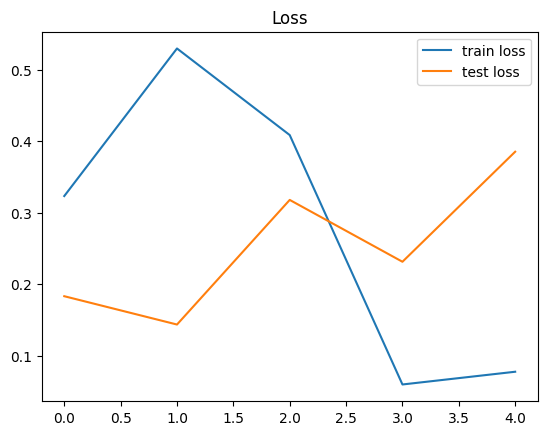

In [ ]:
#convert train_losses in to python list

# to be run only once, since after that the train_losses will contain the values already
train_losses = [t.item() for t in train_losses]
test_losses = [t.item() for t in test_losses]

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

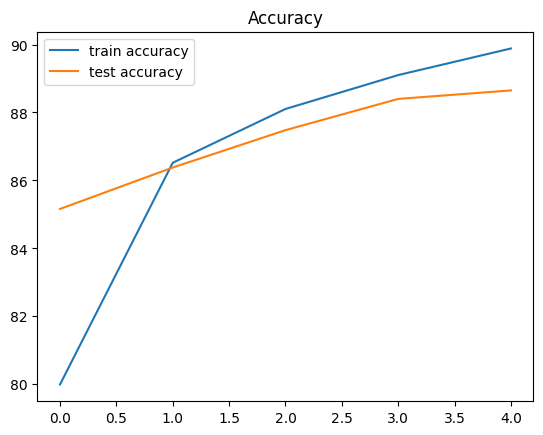

In [ ]:
plt.plot([t4/600 for t4 in train_correct], label = "train accuracy")
plt.plot([t5/100 for t5 in test_correct], label = "test accuracy")
plt.legend()
plt.title("Accuracy")

In [ ]:
test_load_everthing = DataLoader(test_data, batch_size=10000, shuffle=False)


In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everthing:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()



In [ ]:
correct.item()/len(test_data)*100

88.64999999999999

In [ ]:
#Grab an image
test_data[1011][0].reshape(1,1,28,28)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

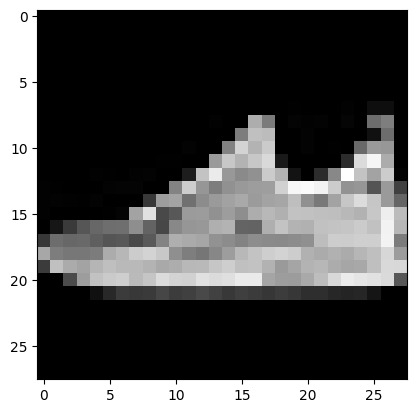

In [ ]:
plt.imshow(test_data[5050][0].reshape(28,28), cmap='gray')
#

In [ ]:
model.eval()
with torch.no_grad():
  newPredicted = model(test_data[5050][0].reshape(1,1,28,28))

newPredicted

tensor([[-1.3646e+01, -1.5356e+01, -1.7960e+01, -1.4695e+01, -1.6358e+01,
         -8.3879e+00, -1.4194e+01, -2.8143e-03, -1.2090e+01, -5.9621e+00]])

In [ ]:
newPredicted.argmax().item()

7

The model predicts the digit in the image is: 0


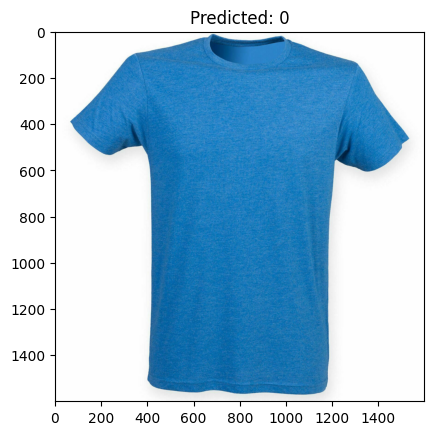

In [ ]:
#Trying to get an image from internet
import requests
from PIL import Image #pillow is used to manipulate imaGES OF ANY FORMAT(png jpg etc.)
import io

# Function to download image from URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))#in comments
    return img

# Function to preprocess the image
def preprocess_image(img):
    img = img.convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to 28x28
    img = np.array(img)  # Convert to numpy array
    img = 255 - img  # Invert colors (MNIST dataset has white text on black background)
    img = img / 255.0  # Normalize pixel values
    img = torch.tensor(img, dtype=torch.float32)  # Convert to tensor
    img = img.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    return img

# URL of the image to be tested
image_url = "https://demo.wpstartersites.com/cordero-demo/wp-content/uploads/sites/12/2020/06/mens-tee-blue.jpg"

img = download_image(image_url)
img_tensor = preprocess_image(img)

# Make prediction
model.eval()
with torch.no_grad():
    prediction = model(img_tensor)
    predicted_label = prediction.argmax().item()

print(f'The model predicts the digit in the image is: {predicted_label}')

# Visualize the image
plt.imshow(img, cmap='gray')
plt.title(f'Predicted: {predicted_label}')
plt.show()

# labels_map = {
#     0: "T-Shirt",
#     1: "Trouser",
#     2: "Pullover",
#     3: "Dress",
#     4: "Coat",
#     5: "Sandal",
#     6: "Shirt",
#     7: "Sneaker",
#     8: "Bag",
#     9: "Ankle Boot",
# }

In [ ]:
torch.save(model.state_dict(), 'fashion_mnist_model.pth')


In [ ]:
model = ConvolutionNetwork()
model.load_state_dict(torch.load('fashion_mnist_model.pth'))

<ipython-input-52-5b374e4a9619>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fashion_mnist_model.pth'))


<All keys matched successfully>